In [72]:
# !apt install gdal-bin python-gdal python3-gdal
# !apt install python3-rtree
# !pip install descartes
# !pip install geopandas
# import geopandas as gpd

# !pip install geopandas --upgrade geopandas
import geopandas as gpd
# !pip install mapclassify
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
%matplotlib inline
import chardet
from scipy.stats import pearsonr
# from sklearn.impute import KNNImputer
import seaborn as sns
import numpy as np
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import mapclassify


gdp = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/income-inequality-to-GDP-assignment/main/gdp-per-capita-penn-world-table.csv",
                  encoding = "utf-8", encoding_errors = 'ignore', usecols=[0, 2, 3])
gini = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/income-inequality-to-GDP-assignment/main/inequality.csv", encoding = "utf-8",
                   encoding_errors = 'ignore', usecols=[0, 1, 2])

gdp.rename(columns={'GDP per capita (output, multiple price benchmarks)': 'GDP per capita', 'Entity': 'Country'}, inplace=True)
gini.rename(columns={'Gini coefficient (before tax) (World Inequality Database)': 'Gini coefficient'}, inplace=True)

unmatched_countries = list(set(gdp['Country'].to_list()) - set(gini['Country'].to_list()))

gini = gini.copy()
gini = gini.loc[~gini["Country"].isin(unmatched_countries), :]
gini = gini.loc[~gini['Country'].str.contains('WID', case=True), :]
gdp = gdp.copy()
gdp = gdp.loc[~gdp["Country"].isin(unmatched_countries), :]

gdp_gini = pd.merge(gdp, gini, on=["Country", "Year"]).set_index('Year')
gdp_gini.interpolate(method='linear', limit=1, limit_direction='forward', axis=0, inplace=True)

df_world = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

df_world['centroid'] = df_world['geometry'].to_crs(epsg=4326).centroid

gdp_gini.replace({"Cote d'Ivoire": "Côte d'Ivoire",
                  'United States': 'United States of America', }, inplace=True)

df_world.replace({'Bosnia and Herz.': 'Bosnia and Herzegovina',
                  'Central African Rep.': 'Central African Republic',
                  'Dem. Rep. Congo': 'Congo',
                  'Dominican Rep.': 'Dominican Republic',
                  'Eq. Guinea': 'Equatorial Guinea',
                  'N. Cyprus': 'Cyprus',
                  'S. Sudan': 'Sudan',
                  'eSwatini': 'Eswatini'}, inplace=True)

continents = df_world.iloc[:,1:3]
continents.rename(columns={'name': 'Country',
                           'continent': 'Continent'}, inplace=True)
gdp_gini = pd.merge(continents, gdp_gini, how='left', on='Country')

grouped = gdp_gini.groupby('Continent')

<ipython-input-72-a74739f88613>:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_world['centroid'] = df_world['geometry'].to_crs(epsg=4326).centroid


In [73]:
# plot

grouped = gdp_gini.groupby('Country')
country_pval = dict()

# berekening
for i in list(set(gdp_gini['Country'].to_list())):
  rho = grouped.get_group(i).corr()
  pval = grouped.get_group(i).corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape) # display(pval)
  warnings.filterwarnings(action="ignore", category= FutureWarning)
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t])) # display(p)
  corr_plus_sign = (rho.round(2).astype(str) + p).iloc[0,1]
  country_pval[i] = [rho.iloc[0,1], corr_plus_sign]

country_pval_df = pd.DataFrame(data=country_pval, index=['corr', 'corr_plus_sign']).T
country_pval_df.index.name = 'Country'
country_pval_df.reset_index(inplace=True)

df_world_pval_df = df_world.merge(country_pval_df, how="left", left_on=['name'], right_on=['Country'])
df_world_pval_df = df_world_pval_df.copy()
df_world_pval_df = df_world_pval_df[df_world_pval_df.continent != 'Antarctica']
totaal = df_world_pval_df['corr_plus_sign'].count() # 176

totaal_nan_df = df_world_pval_df.loc[df_world_pval_df['corr_plus_sign']=='nan', :]   # 'corr_plus_sign'
totaal_nan = totaal_nan_df.loc[:, 'Country'].count() # 36

df_world_pval_df_p_no_asterix = df_world_pval_df.loc[~df_world_pval_df['corr_plus_sign'].str.contains(r'[*]', regex=True), :]
totaal_niet_significant = df_world_pval_df_p_no_asterix['corr_plus_sign'].count() # 96

df_world_pval_df_p = df_world_pval_df.loc[df_world_pval_df['corr_plus_sign'].str.contains(r'[*]+', regex=True), :]
totaal_significant_niet_nan = df_world_pval_df_p['corr_plus_sign'].count() # 80

df_world_pval_df_p_no_asterix_no_nan = df_world_pval_df_p_no_asterix.loc[df_world_pval_df_p_no_asterix['corr_plus_sign']!='nan', :]
totaal_niet_significant_niet_nan = df_world_pval_df_p_no_asterix_no_nan.loc[:, 'corr_plus_sign'].count()

data = [[0, totaal_nan, totaal_nan+0],
        [totaal_significant_niet_nan, totaal_niet_significant_niet_nan, totaal_significant_niet_nan+totaal_niet_significant_niet_nan],
        [totaal_significant_niet_nan+0, totaal_nan+totaal_niet_significant_niet_nan, totaal_nan+0+totaal_significant_niet_nan+totaal_niet_significant_niet_nan]]

multi_columns = pd.MultiIndex.from_tuples([('Significant', 'Wel'), ('Significant', 'Niet'), ('Significant', 'Totaal')])
multi_index = pd.MultiIndex.from_tuples([('nan', 'Wel'), ('nan', 'Niet'), ('nan', 'Totaal')])
matrix = pd.DataFrame(data, index=multi_index, columns=multi_columns)


Significant            
                   Wel Niet Totaal
nan Wel              0   36     36
    Niet            80   60    140
    Totaal          80   96    176

(-198.0, 198.00000000000006, -62.574678, 90.607978)

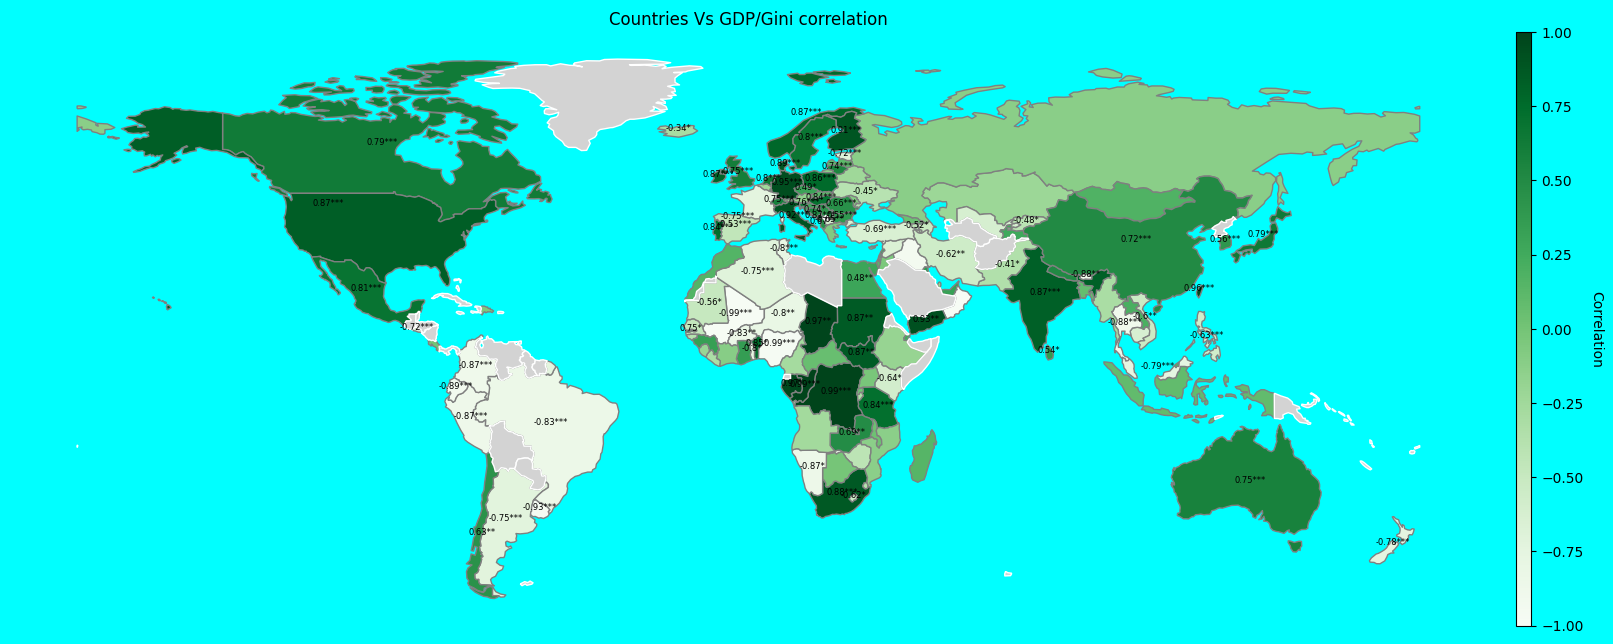

In [74]:
display(matrix)

fig, ax = plt.subplots(1, 1, figsize=(20, 16), facecolor ='Cyan') # 20, 16
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad="0.05%")

# kleurplot van alle correlaties, significant of niet
plot = df_world_pval_df.plot(column="corr", ax=ax, cmap='Greens', cax=cax, legend=False, legend_kwds={'label': "Population by Country",  # 'OrRd'
                                                                                             'orientation': "horizontal"},
                                                                                              missing_kwds={'color': 'lightgrey',
                                                                                                            "edgecolor": "white", "hatch": ''},
                                                                                              edgecolors ='grey')

df_world_pval_df_p = df_world_pval_df_p.sort_values('corr_plus_sign', ascending=False)

# notatie voor de landen met significante correlaties. De groep bestaat uit 80 (van 176) landen.
df_world_pval_df_p.apply(lambda x: ax.annotate(text=x['corr_plus_sign'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', size=6, ), axis=1) # color='?'-----

# create colorbar
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = ax.figure.colorbar(mappable=plt.gci(), norm=norm, cax=cax, use_gridspec=True, location='right', spacing='proportional', drawedges=False, cmap='Greens')
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
ax.set_title("Countries Vs GDP/Gini correlation")
ax.axis('off')


##Is there a relation between a country's Gross Domestrict Product (GDP) and its income inequality?

#####Volgens mij is het antwoord op deze vraag JA. De donkergroene landen zijn in de meerderheid (grijs wil zeggen: geen data). Dat betekent dan per saldo een positieve correlatie. Ook zijn de scores overwegend significant; 80 vs 60. Dat is 4 van de 7 keer.

